In [1]:
# On utilise les librairies tabular (données structurées) et collab pour le filtrage collaboratif. 
from fastai2.collab import *
from fastai2.tabular.all import *

In [2]:
# FastAi propose un jeux de données du site Movie Lens. C'est un sous ensemble de 100.000 notes par des utilisateurs. 
path = untar_data(URLs.ML_100k)

In [3]:
# On charge les données du fichier csv fourni pour voir à quoi elles ressemblent. 
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user','movie','rating','timestamp'])
# On affiche les 10 premières lignes
ratings.head(10)

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [4]:
# On récupére le nom des films pour les id fournis dans le fichier précédent. 
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', 
                     usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
# La librairie panda permet de merge les données basé sur le nom de la colonne
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [6]:
# FastAI propose des DataLoader spécifiques (Comportement par défaut pour filtrage collaboratif)
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,933,Under Siege (1992),2
1,682,Hoodlum (1997),4
2,453,Dead Man Walking (1995),3
3,721,Back to the Future (1985),5
4,624,"Rock, The (1996)",3
5,141,Twister (1996),5
6,276,"Usual Suspects, The (1995)",5
7,588,When Harry Met Sally... (1989),5
8,728,Secrets & Lies (1996),4
9,721,Return of the Jedi (1983),5


In [7]:
# On récupére le nombre d'utilisateur et de films contenus dans notre jeux de données
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

In [8]:
# Le principe que l'on va appliqué correspond aux "caractéristiques latentes". l'idées est d'attribuer x caractéristiques 
# aléatoires au éléments (film et user ici). Ces caractèristiques correspondraient à des types de films (SF, Romantique, 
# ...). On va ensuite grace aux machine learning essayé de déterminer ses caractèristiques pour chaque élément en fonction
# des notes attribuées. 
# Exemple: User1 [0.1, 0.9] (Aime pas trop la SF mais bien le Romantique)
#          Film1 [0.9, 0.2], Film2 [0.1, 0.8]
# Si je multiplie les caractérisque de mon utilisateur à celle des films 0.1*0.9 + 0.9*0.2 et 0.1*0.1 + 0.9*0.8 j'obtiens 
# un résultat nettement supérieur pour le second film (il est romantique et l'utilisateur aime les film romantique)
# Dans les fait les "caractéristiques latentes" ne sont pas définies, on ne sait pas à quoi elles correspondent. 

# On initialise donc 5 caractéristiques aléatoirement pour les utilisateurs et les films

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)
user_factors[0]


tensor([ 0.6217,  0.0038, -0.6626,  0.0975, -0.0779])

In [12]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [50]:
# Tests Compréhension

# Embedding crée un "dictionnaire" avec le nombre d'occurence demandées en 1er paramètre (nb user) et un "tableau" de taille
# x passé en second paramètre.
# x[:,0] renvoit l'ensemble des id des utilisateurs du batch en cours (x). L'accès user_factors(x[:,0]) rend les "tableaux"
# de paramètre créés pour chaque utilisateur. On utilise leur ID comme clefs d'accès ici. 
# Le retour de la méthode forward est un tensor de y résultats (y=nombre de paramètre) correspondant à 
# paramètre1 user * paramètre1 movie.

# A priori on a écrit le model mais pas l'optimiser qui fait les ajustements de gradient. 
# Je ne comprends pas comment le learner qui doit avoir un Optimizer par défaut peut-il savoir ou sont mes paramètres 
# (ici user_factors & movie_factors)

# Le module Embedding retourne un objet de type Parameters (PyTorch) c'est probablement ce qui permet de faire le lien.

x,y = dls.one_batch()
uf = Embedding(n_users, n_factors)
mf = Embedding(n_movies, n_factors)

testModel = DotProduct(n_users, n_movies, n_factors)

In [13]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [14]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.279468,1.296067,00:17
1,1.091481,1.114914,00:17
2,0.978249,0.991923,00:17
3,0.852166,0.899882,00:18
4,0.782758,0.883113,00:18


In [15]:
# On améliore le modèle en lui indiquant la "range" de la sortie à déterminer
class DotProduct(Module):
    # On passe 5.5 pour permettre au modèle d'atteindre 5 (lié au fonctionnement de sigmoid)
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)): 
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range) # Application de sigmoid avec la range

In [16]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.004665,1.005154,00:27
1,0.845934,0.916348,00:27
2,0.665111,0.882851,00:27
3,0.471844,0.888404,00:28
4,0.362242,0.892959,00:27


In [44]:
# On essaye d'ajouter un biais pour l'utilisateur et le film. Pour gérer les cas de figure: 
# Film excellent ou nul peut importe le type
# Utilisateur jamais content ou toujours content

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)): 
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range) 

In [45]:
# On voit un surentrainement dans les résultat. L'erreur sur les données d'entrainement diminue (train_loss) en revanche 
# sur le jeux de validation l'erreur se met à remonter à partier de la 4eme epoque. On parle de surspécialisation. 
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.948788,0.939378,00:15
1,0.813435,0.868090,00:15
2,0.626275,0.866879,00:15
3,0.395660,0.887145,00:14
4,0.296874,0.893588,00:15


In [88]:
# On utilise la méthode weight decay pour éviter le surentrainement. Cela va inciter le modèle à ne pas utiliser 
# un trop grand nombre de paramètres (voir cours). 

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

# On voit que cela complique l'entrainement puisque le train loss diminue beaucoup moins rapidement. En revanche on a
# bien améliorer le résultat sur le jeux de validation. 

epoch,train_loss,valid_loss,time
0,0.954284,0.940237,00:15
1,0.860161,0.884900,00:14
2,0.754815,0.841686,00:14
3,0.582411,0.826753,00:14
4,0.492887,0.827352,00:14


In [89]:
# On peut noter que le biais rajouté de cette manière peut être interpréter. Si l'on prends la valeur brute du biais 
# film par exemple les films qui auront le biais le plus élevés seront aimés indiféremment du type (autres carac latentes)

learn.model.cpu() # Corrige un soucis entre cuda et cpu pas bien compris. Sinon les infos ne sont pas récupérables. 
#learn.model.movie_bias(torch.from_numpy(np.arange(0,1637))).squeeze()
learn.model.movie_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:10] # 10 plus grands
[dls.classes['title'][i] for i in idxs]

# Les films les plus aimés sont donc

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Rear Window (1954)',
 'Star Wars (1977)',
 'Silence of the Lambs, The (1991)',
 'Wrong Trousers, The (1993)',
 'Good Will Hunting (1997)',
 'To Kill a Mockingbird (1962)']

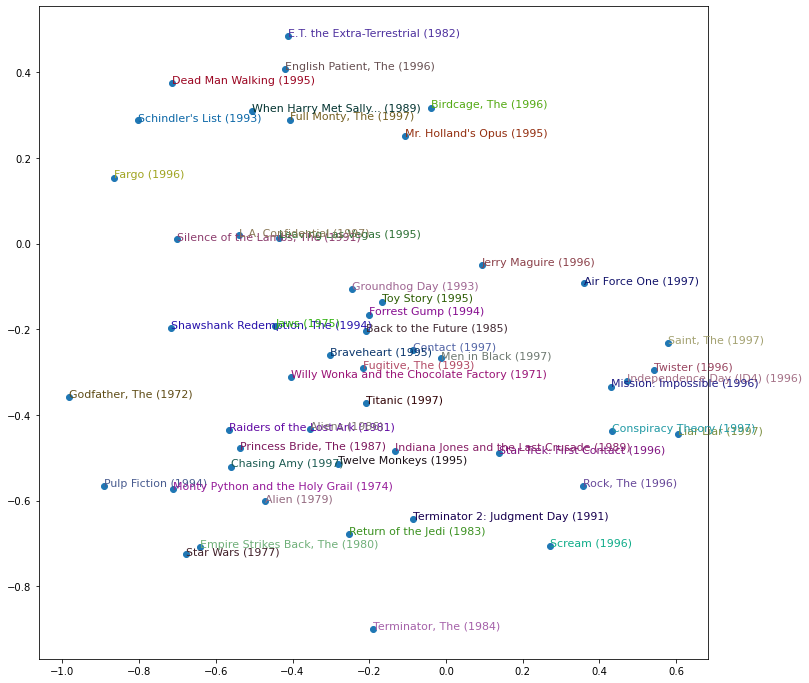

In [82]:
# On peut essayer de regrouper les films en fonction des caractèrisques latentes que l'on a utilisées. 
# On voit que les films d'un même "genre" ont été regroupés. 


g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])

movie_w = learn.model.movie_factors(torch.from_numpy(np.arange(0,1637)))[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()

idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [84]:
# On peut utiliser directement le système intgéré collab_learner

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [85]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.938532,0.939806,00:15
1,0.828847,0.877570,00:15
2,0.723518,0.839858,00:15
3,0.589287,0.827275,00:15
4,0.500340,0.828596,00:15


In [86]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:10] # 10 plus grands
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Rear Window (1954)',
 'Star Wars (1977)',
 'Silence of the Lambs, The (1991)',
 'Wrong Trousers, The (1993)',
 'Good Will Hunting (1997)',
 'To Kill a Mockingbird (1962)']

In [91]:
# On peut compléxifier un peu le modèle en créant un réseaux de neurones plutot qu'uniquement un produit scalaire 
# Cela permet également d'utiliser des tailles différentes pour les deux jeux de paramètres (utilisateurs / films)

class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act), # Addition des activations 
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [92]:
# La méthode get_emb_sz renvoit les tailles recommandées par fastAi pour les tableaux de paramètres (caractèristiques latentes) 
embs = get_emb_sz(dls)
embs

[(944, 74), (1637, 101)]

In [93]:
model = CollabNN(*embs)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.947458,0.940167,00:17
1,0.898788,0.900393,00:17
2,0.836836,0.878226,00:15
3,0.801642,0.866147,00:16
4,0.783333,0.871238,00:15
